In [40]:
import torch
import torch.nn as nn
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
from IPython.display import clear_output

In [7]:
path = "/content/drive/MyDrive/DLE/cifar10/"
dataset_train = CIFAR10(path, train=True)

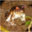

In [8]:
dataset_train[0][0]

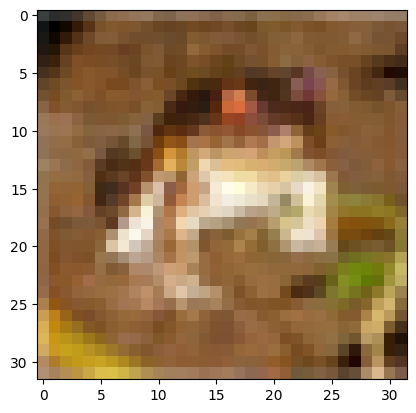

In [9]:
plt.imshow(dataset_train[0][0])
plt.show()

In [10]:
dataset_train = CIFAR10(path, train=True, transform=T.ToTensor())

In [11]:
dataset_train.data.shape

(50000, 32, 32, 3)

In [12]:
means = (dataset_train.data / 255).mean(axis=(0, 1, 2))
means

array([0.49139968, 0.48215841, 0.44653091])

In [13]:
stds = (dataset_train.data / 255).std(axis=(0, 1, 2))
stds

array([0.24703223, 0.24348513, 0.26158784])

In [37]:
train_transforms = T.Compose(
    [
        T.RandomResizedCrop(size=32, scale=(0.8, 1.1)),
        T.RandomHorizontalFlip(p=0.5),
        T.ToTensor(),
        T.Normalize(mean=means, std=stds)
    ]
)

test_transforms = T.Compose(
    [
        T.ToTensor(),
        T.Normalize(mean=means, std=stds)
    ]
)

In [38]:
train_dataset = CIFAR10(path, train=True, transform=train_transforms)
valid_dataset = CIFAR10(path, train=False, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

In [16]:
def train(model, loader) -> float:
    model.train()

    train_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc="Train"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = loss_fn(output, y)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    train_loss /= len(train_loader)
    accuracy = correct / total

    return train_loss, accuracy

In [17]:
@torch.inference_mode()
def evaluate(model, loader):
    model.eval()

    valid_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc="Evaluation"):
        x, y = x.to(device), y.to(device)

        output = model(x)
        loss = loss_fn(output, y)
        valid_loss += loss.item()

        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    valid_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy

In [18]:
def plot_stats(
        train_loss: list[float],
        valid_loss: list[float],
        train_accuracy: list[float],
        valid_accuracy: list[float],
        title: str
):

    plt.figure(figsize=(10, 5))
    plt.title(title+ " loss")

    plt.plot(train_loss, label="Train loss")
    plt.plot(valid_loss, label="Valid loss")
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.title(title+ " accuracy")

    plt.plot(train_accuracy, label="Train accuracy")
    plt.plot(valid_accuracy, label="Valid accuracy")
    plt.legend()
    plt.grid()
    plt.show()

In [39]:
def whole_train_valid_cycle(model, num_epochs, title, sched=False):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history= [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model, train_loader)
        valid_loss, valid_accuracy = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )

        if sched:
            scheduler.step()

In [20]:
class FirstModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.in_channels = 3
        self.hidden_dim = 16
        self.size_fc = 1024
        self.size_out = 10
        self.kernel = 3
        self.pool = 2
        self.img_size = 32

        self.net = nn.Sequential(
            nn.Conv2d(in_channels=self.in_channels, out_channels=self.hidden_dim, kernel_size=self.kernel, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(self.pool),

            nn.Conv2d(in_channels=self.hidden_dim, out_channels=self.hidden_dim * 2, kernel_size=self.kernel, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(self.pool),

            nn.Flatten(),

            nn.Linear(int(self.img_size / self.pool / self.pool) ** 2 * self.hidden_dim * 2, self.size_fc),
            nn.ReLU(),
            nn.Linear(self.size_fc, int(self.size_fc / 8)),
            nn.ReLU(),
            nn.Linear(int(self.size_fc / 8), self.size_out)

        )

    def forward(self, x):
        return self.net(x)

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

loss_fn = nn.CrossEntropyLoss()

cuda:0


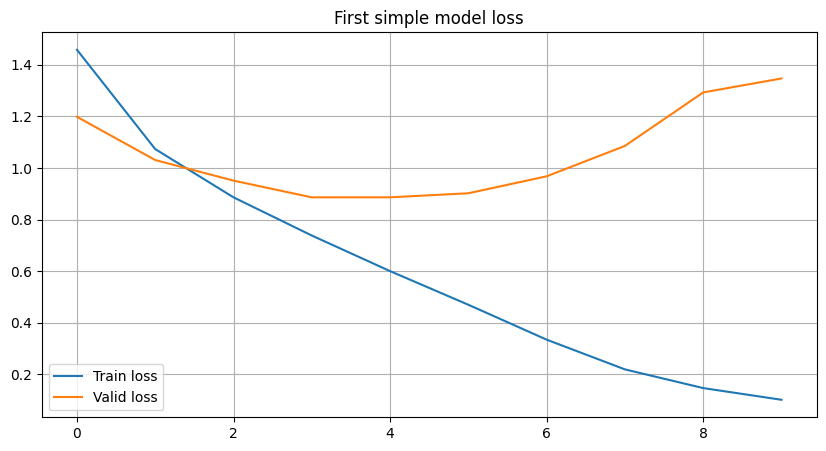

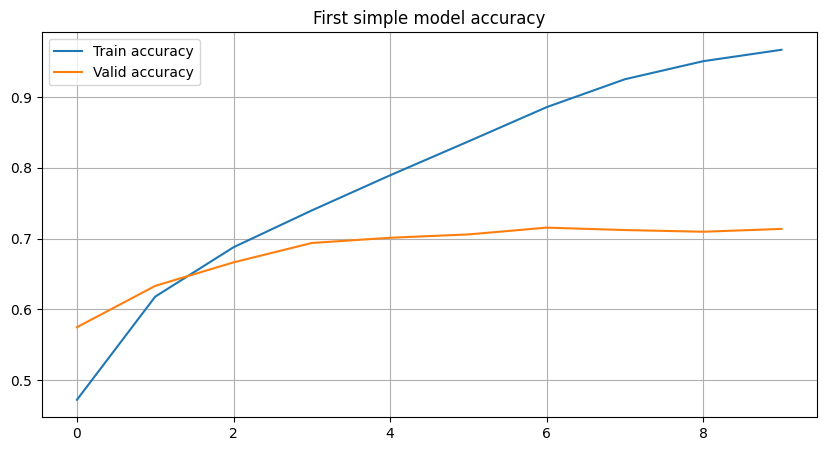

In [22]:
model = FirstModel().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
whole_train_valid_cycle(model, 10, "First simple model")

In [32]:
class BatchnormDropoutModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.in_channels = 3
        self.hidden_dim = 16
        self.size_fc = 512
        self.size_out = 10
        self.kernel = 3
        self.pool = 2
        self.img_size = 32
        self.p = 0.3

        self.net = nn.Sequential(
            nn.Conv2d(in_channels=self.in_channels, out_channels=self.hidden_dim, kernel_size=self.kernel, padding=1),
            nn.BatchNorm2d(self.hidden_dim),
            nn.ReLU(),

            nn.Conv2d(in_channels=self.hidden_dim, out_channels=self.hidden_dim * 2, kernel_size=self.kernel, padding=1),
            nn.BatchNorm2d(self.hidden_dim * 2),
            nn.ReLU(),

            nn.MaxPool2d(self.pool),
            nn.Dropout(self.p),

            nn.Conv2d(in_channels=self.hidden_dim * 2, out_channels=self.hidden_dim * 4, kernel_size=self.kernel, padding=1),
            nn.BatchNorm2d(self.hidden_dim * 4),
            nn.ReLU(),

            nn.Conv2d(in_channels=self.hidden_dim * 4, out_channels=self.hidden_dim * 4, kernel_size=self.kernel, padding=1),
            nn.BatchNorm2d(self.hidden_dim * 4),
            nn.ReLU(),

            nn.MaxPool2d(self.pool),
            nn.Dropout(self.p),

            nn.Conv2d(in_channels=self.hidden_dim * 4, out_channels=self.hidden_dim * 8, kernel_size=self.kernel, padding=1),
            nn.BatchNorm2d(self.hidden_dim * 8),
            nn.ReLU(),

            nn.Conv2d(in_channels=self.hidden_dim * 8, out_channels=self.hidden_dim * 8, kernel_size=self.kernel, padding=1),
            nn.BatchNorm2d(self.hidden_dim * 8),
            nn.ReLU(),

            nn.MaxPool2d(self.pool),
            nn.Dropout(self.p),

            nn.Flatten(),

            nn.Linear(int(self.img_size / ((self.pool) ** 3)) ** 2 * (self.hidden_dim * 8), self.size_fc),
            nn.BatchNorm1d(self.size_fc),
            nn.Dropout(self.p),
            nn.ReLU(),
            nn.Linear(self.size_fc, self.size_out)
        )

    def forward(self, x):
        return self.net(x)

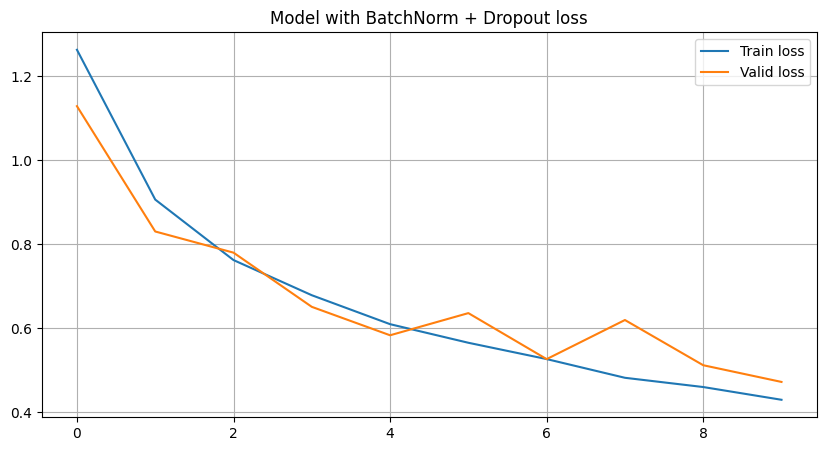

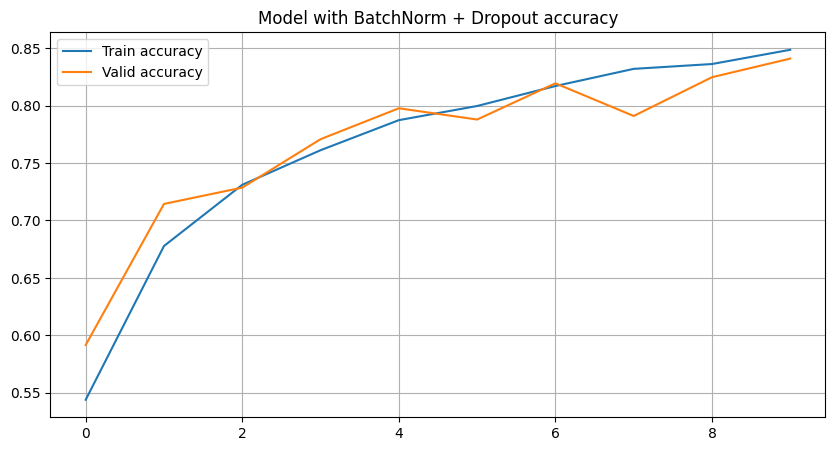

In [33]:
model = BatchnormDropoutModel().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
whole_train_valid_cycle(model, 50, "Model with BatchNorm + Dropout")

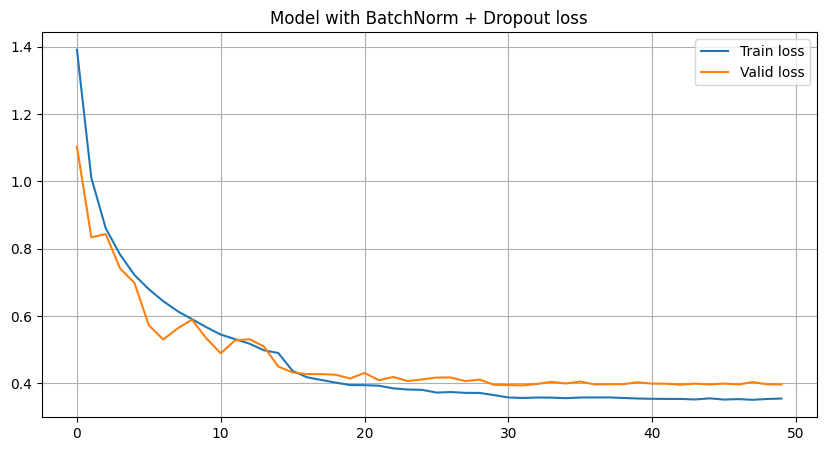

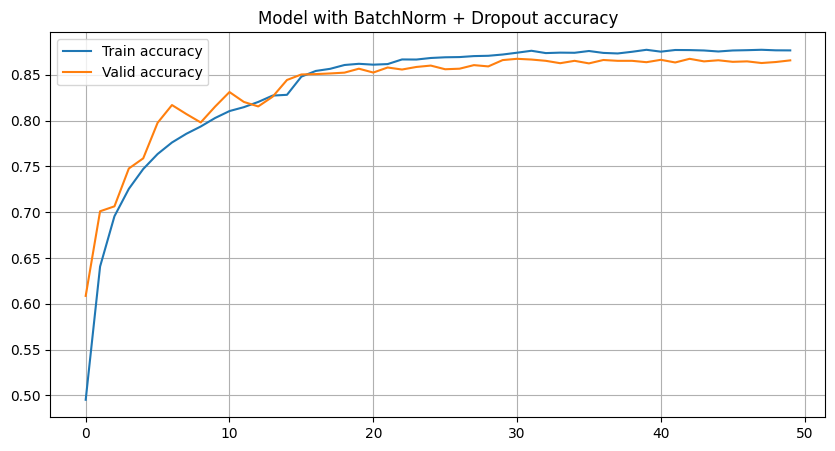

In [41]:
model = BatchnormDropoutModel().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=15)
whole_train_valid_cycle(model, 50, "Model with BatchNorm + Dropout", sched=True)